In [1]:
library(tidyverse)
library(caret)
library(keras)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [2]:
train <- read_csv("data/train.csv")
test <- read_csv("data/test.csv")

Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.


In [3]:
train_index <- createDataPartition(train$label, p=0.9, list=FALSE)
cv_train <- train[train_index, ]
cv_validation <- train[-train_index, ]

In [4]:
train_data <- select(cv_train, -label)
train_labels <- cv_train$label

validation_data <- select(cv_validation, -label)
validation_labels <- cv_validation$label

In [5]:
x_train <- data.matrix(train_data)
x_valid <- data.matrix(validation_data)

In [6]:
y_train <- to_categorical(train_labels, 10)
y_valid <- to_categorical(validation_labels, 10)

In [7]:
x_train <- x_train / 255
x_valid <- x_valid / 255

# Modeling

In [8]:
model <- keras_model_sequential() 
model %>% 
  layer_dense(units = 256, activation = 'relu', input_shape = c(784)) %>% 
  layer_dropout(rate = 0.4) %>% 
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = 10, activation = 'softmax')

In [9]:
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 256)                     200960      
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 256)                     0           
________________________________________________________________________________
dense_2 (Dense)                     (None, 128)                     32896       
________________________________________________________________________________
dropout_2 (Dropout)                 (None, 128)                     0           
________________________________________________________________________________
dense_3 (Dense)                     (None, 10)                      1290        
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_____________________________________

In [10]:
model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

In [11]:
history <- model %>% fit(
    x_train, y_train, 
    epochs = 30, 
    batch_size = 128, 
    validation_data = list(x_valid, y_valid)
)

# Model evaluation

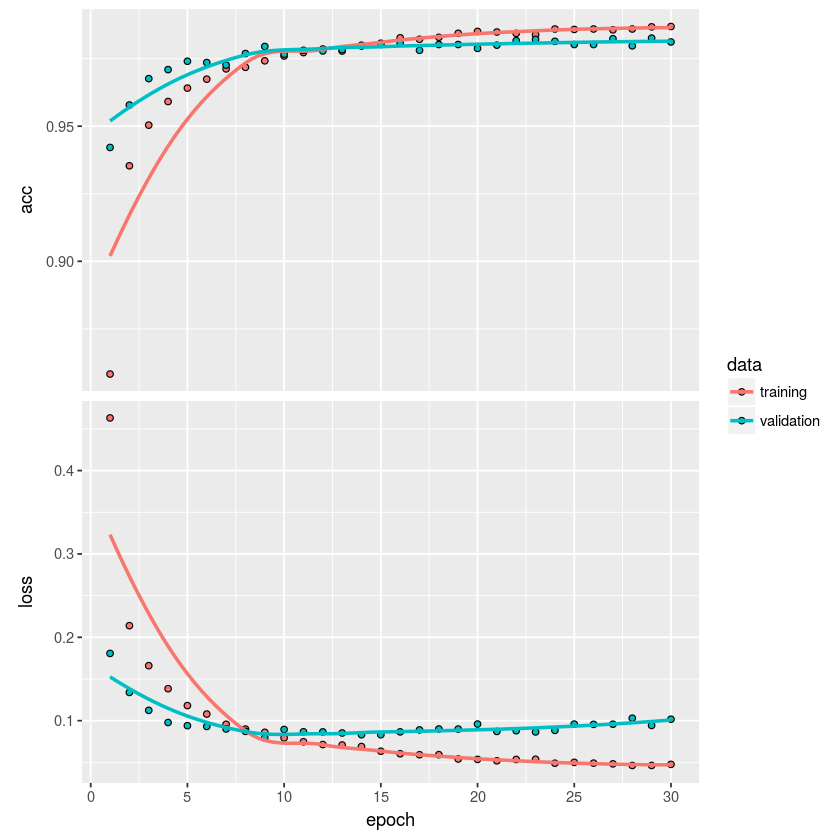

In [12]:
plot(history)

In [13]:
as_labels <- function(predictions) {
    data <- as_tibble(predictions)
    colnames(data) <- 0:9
    return(
        as.integer(colnames(data)[max.col(data, ties.method="first")])
    )
}

In [14]:
predictions <- model %>% predict(x_valid, batch_size = 128)
pred_labels <- as_labels(predictions)

confusion_matrix <- caret::confusionMatrix(
    table(predicted=pred_labels, actual=validation_labels)
)

In [15]:
confusion_matrix

Confusion Matrix and Statistics

         actual
predicted   0   1   2   3   4   5   6   7   8   9
        0 429   0   1   0   0   0   3   0   1   0
        1   0 458   1   0   1   1   0   2   0   0
        2   2   3 395   4   0   0   0   1   2   1
        3   0   4   1 422   0   7   0   0   1   0
        4   0   0   2   0 400   0   1   0   0   1
        5   0   0   1   7   0 387   1   1   3   1
        6   0   0   0   0   0   2 387   0   1   0
        7   0   0   1   0   1   0   0 434   1   4
        8   0   1   0   2   0   1   0   0 400   1
        9   0   0   0   2   3   2   0   3   0 408

Overall Statistics
                                          
               Accuracy : 0.9812          
                 95% CI : (0.9766, 0.9851)
    No Information Rate : 0.111           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9791          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

              

# Sending to Kaggle

In [16]:
x_kaggle_train <- data.matrix(select(train, -label))
y_kaggle_train <- train$label

In [17]:
x_kaggle_train <- x_kaggle_train / 255
y_kaggle_train <- to_categorical(y_kaggle_train, 10)

In [18]:
kaggle_test <- data.matrix(test)
kaggle_test <- kaggle_test / 255

In [19]:
model <- keras_model_sequential() 
model %>% 
  layer_dense(units = 256, activation = 'relu', input_shape = c(784)) %>% 
  layer_dropout(rate = 0.4) %>% 
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = 10, activation = 'softmax')

In [20]:
model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

In [21]:
model %>% fit(
    x_kaggle_train, y_kaggle_train, 
    epochs = 30, 
    batch_size = 128
)

In [22]:
predictions <- model %>% predict(kaggle_test, batch_size = 128)

In [23]:
write_predictions_to_csv <- function(predictions, file_name) {
    pred_labels <- as_labels(predictions)
    predictions <- tibble(
        ImageId=1:length(pred_labels), 
        Label=pred_labels
    )
    write_csv(predictions, file_name)
}

In [24]:
write_predictions_to_csv(predictions, "results/simple_nn.csv")

# CNN model

In [25]:
img_rows <- 28
img_cols <- 28

In [26]:
input_shape <- c(img_rows, img_cols, 1)

In [27]:
model <- keras_model_sequential()
model %>%
  layer_conv_2d(filters = 32, kernel_size = c(3,3), activation = 'relu',
                input_shape = input_shape) %>% 
  layer_conv_2d(filters = 64, kernel_size = c(3,3), activation = 'relu') %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_dropout(rate = 0.25) %>% 
  layer_flatten() %>% 
  layer_dense(units = 128, activation = 'relu') %>% 
  layer_dropout(rate = 0.5) %>% 
  layer_dense(units = 10, activation = 'softmax')

In [28]:
model %>% compile(
  loss = loss_categorical_crossentropy,
  optimizer = optimizer_adadelta(),
  metrics = c('accuracy')
)

In [29]:
x_kaggle_train <- array_reshape(x_kaggle_train, c(nrow(x_kaggle_train), img_rows, img_cols, 1))

In [30]:
model %>% fit(
  x_kaggle_train, y_kaggle_train, 
  batch_size = 128,
  epochs = 20
)

In [31]:
kaggle_test <- array_reshape(kaggle_test, c(nrow(kaggle_test), img_rows, img_cols, 1))

In [32]:
predictions <- model %>% predict(kaggle_test, batch_size = 128)

In [33]:
write_predictions_to_csv(predictions, "results/cnn.csv")